Saving updated_covid19_germany_federalstates.csv to updated_covid19_germany_federalstates (2).csv
   id Country/Region       federalstate  infections  deaths        date  \
0   1        Germany  Baden-Württemberg          10       0  2020-02-28   
1   2        Germany            Bavaria          15       0  2020-02-28   
2   3        Germany             Berlin           0       0  2020-02-28   
3   4        Germany        Brandenburg           0       0  2020-02-28   
4   5        Germany             Bremen           0       0  2020-02-28   

   newinfections  newdeaths       temp  vaccination_percentage  \
0             10          0  16.236204               76.543821   
1             15          0  33.521429               85.681497   
2              0          0  26.959818               94.902447   
3              0          0  22.959755               46.424946   
4              0          0   9.680559               57.952114   

           riskzone  
0  Blue/Yellow Zone  
1  Blue/Ye

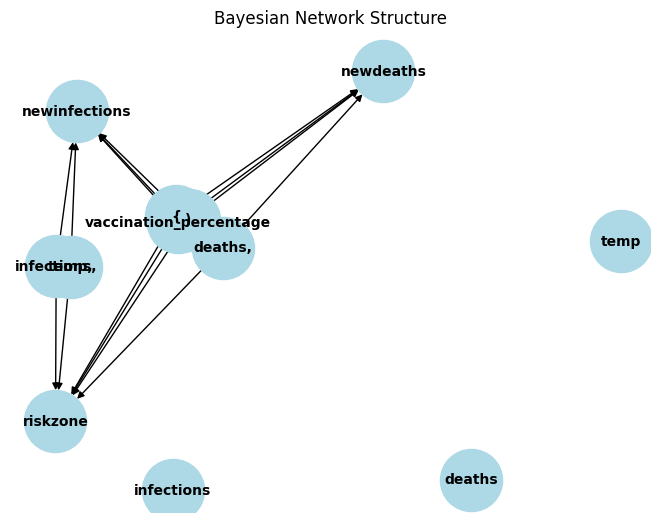

riskzone
Red Zone            1124
Orange Zone          398
Blue/Yellow Zone     110
Name: count, dtype: int64


In [6]:
!pip install pandas numpy pgmpy

!pip install imbalanced-learn


import pandas as pd
import numpy as np
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator
from pgmpy.inference import VariableElimination
from google.colab import files


uploaded = files.upload()
data = pd.read_csv(next(iter(uploaded)))

print(data.head())
print(data.info())

from imblearn.over_sampling import SMOTE

X = data[['infections', 'deaths', 'temp', 'vaccination_percentage', 'newinfections', 'newdeaths']]
y = data['riskzone']


smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

data_resampled = pd.DataFrame(X_resampled, columns=X.columns)
data_resampled['riskzone'] = y_resampled

print(data_resampled['riskzone'].value_counts())


print("Available columns:", data.columns.tolist())


model = BayesianNetwork([
    ('infections', 'riskzone'),
    ('deaths', 'riskzone'),
    ('temp', 'riskzone'),
    ('vaccination_percentage', 'riskzone'),
    ('infections', 'newinfections'),
    ('deaths', 'newdeaths'),
    ('vaccination_percentage', 'newinfections'),
    ('vaccination_percentage', 'newdeaths'),
    ('temp', 'newinfections')
])

for col in ['infections', 'deaths', 'temp', 'vaccination_percentage', 'newinfections', 'newdeaths']:
    data[col] = pd.cut(data[col], bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])


model.fit(data, estimator=BayesianEstimator, prior_type="BDeu")

inference = VariableElimination(model)


def predict_risk_zone(infections, deaths, temp, vaccination):
    evidence = {
        'infections': infections,
        'deaths': deaths,
        'temp': temp,
        'vaccination_percentage': vaccination
    }


    result = inference.query(variables=['riskzone'], evidence=evidence)

    yellow_prob = result.values[0]
    orange_prob = result.values[1]
    red_prob = result.values[2]

    max_prob = max(yellow_prob, orange_prob, red_prob)
    if max_prob == yellow_prob:
        return 'Yellow', yellow_prob
    elif max_prob == orange_prob:
        return 'Orange', orange_prob
    else:
        return 'Red', red_prob



def discretize_value(value, variable_name):
    if variable_name in ['infections', 'deaths', 'newinfections', 'newdeaths']:
        if value <= 200:
            return 'Very Low'
        elif value <= 400:
            return 'Low'
        elif value <= 600:
            return 'Medium'
        elif value <= 800:
            return 'High'
        else:
            return 'Very High'
    elif variable_name == 'temp':

        if value <= 10:
            return 'Very Low'
        elif value <= 20:
            return 'Low'
        elif value <= 30:
            return 'Medium'
        elif value <= 40:
            return 'High'
        else:
            return 'Very High'
    elif variable_name == 'vaccination_percentage':

        if value <= 20:
            return 'Very Low'
        elif value <= 40:
            return 'Low'
        elif value <= 60:
            return 'Medium'
        elif value <= 80:
            return 'High'
        else:
            return 'Very High'

def get_numeric_input():
    print("Please enter the following information in numeric form:")
    infections = float(input("Number of infections (e.g., 0-1000): "))
    deaths = float(input("Number of deaths (e.g., 0-1000): "))
    temp = float(input("Temperature (in °C, e.g., -10 to 50): "))
    vaccination = float(input("Vaccination percentage (0-100): "))

    infections_cat = discretize_value(infections, 'infections')
    deaths_cat = discretize_value(deaths, 'deaths')
    temp_cat = discretize_value(temp, 'temp')
    vaccination_cat = discretize_value(vaccination, 'vaccination_percentage')

    return infections_cat, deaths_cat, temp_cat, vaccination_cat


user_infections, user_deaths, user_temp, user_vaccination = get_numeric_input()

predicted_zone, probability = predict_risk_zone(
    infections=user_infections,
    deaths=user_deaths,
    temp=user_temp,
    vaccination=user_vaccination
)

print(f"\nPredicted Risk Zone: {predicted_zone}")
print(f"Probability: {probability:.2f}")


from pgmpy.readwrite import BIFWriter
import networkx as nx
import matplotlib.pyplot as plt

writer = BIFWriter(model)
writer.write_bif('model.bif')

G = nx.DiGraph()
with open('model.bif', 'r') as f:
    for line in f:
        if line.startswith('probability'):
            parts = line.split('|')
            child = parts[0].split('(')[1].split(')')[0].strip()
            if len(parts) > 1:
                parents = parts[1].strip().split()
                for parent in parents:
                    G.add_edge(parent, child)
            else:
                G.add_node(child)

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=10, font_weight='bold')
edge_labels = {(u, v): '' for u, v in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("Bayesian Network Structure")
plt.axis('off')
plt.show()

print(data['riskzone'].value_counts())